# Libraries

In [1]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import (
    col, count, when, isnan, split, size,
    array_min, array_max, array_distinct, to_timestamp,
    spark_partition_id
)
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import pyspark.sql.functions as f
from pyspark.sql.functions import when, col
from pyspark.sql.functions import year
from pyspark.sql.functions import to_dat
import pyspark.sql.functions as psf
from pyspark.sql.functions import col,isnan, when, count

import pandas as pd
pd.set_option('display.max_columns', None)

# import psycopg2

from tqdm import tqdm
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425350 sha256=254e7f8fd6dd51fc180ca5e54e68f0bbdf0a1d2c380f9d53b7017b5f0f94cc81
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Extracting yelp_dataset.tar file

In [2]:
import tarfile


tar_file = tarfile.open('/input/yelp-reviews/yelp_dataset.tar', 'r')
tar_file.extractall()
tar_file.close()

In [4]:
os.listdir('/working/')

['yelp_academic_dataset_user.json',
 'yelp_academic_dataset_checkin.json',
 'yelp_academic_dataset_business.json',
 'yelp_academic_dataset_tip.json',
 '.virtual_documents',
 'yelp_academic_dataset_review.json',
 'Dataset_User_Agreement.pdf']

**There are total of 5 datasets: - User, Business, Reviews, Checkin and Tip**

# Setting up PySpark

In [6]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "10g") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .appName("Yelp Review Sense") \
    .getOrCreate()

# //to supress log messages//
spark.sparkContext.setLogLevel("OFF") 


# 1. Preparing User Data

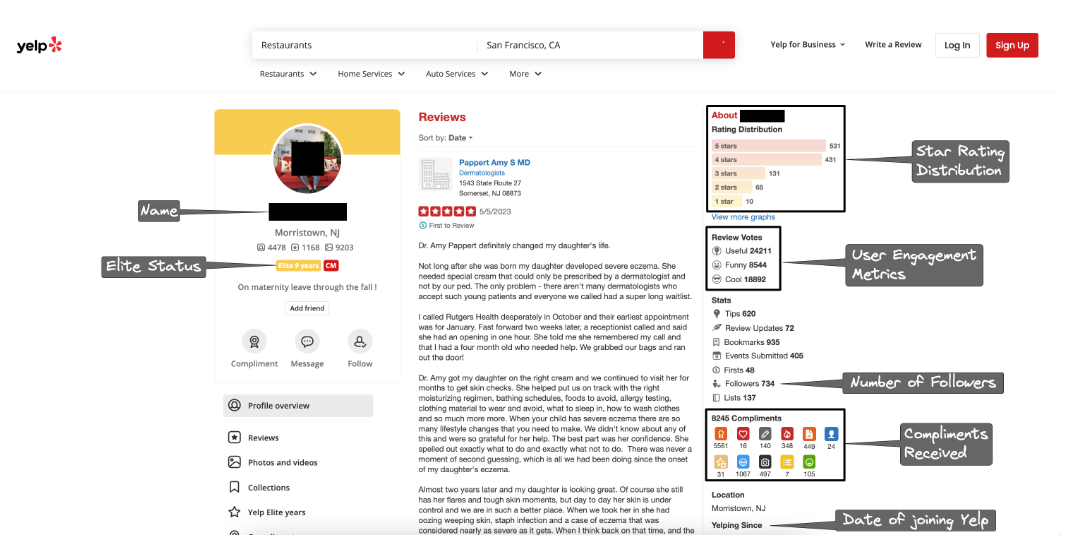

In [21]:
df_user = spark.read.json('yelp_academic_dataset_user.json')
print('The user data contains {} rows and {} columns'.format(df_user.count(), len(df_user.columns)),'\n')
print(df_user.printSchema(),'\n')

The user data contains 1987897 rows and 22 columns 

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

None 



In [22]:
df_user.limit(10).toPandas().head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.91,467,56,467,250,18,65,232,180,844,55,239,5994,2007,267,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",1259,Walker,585,7217,qVc8ODYU5SZjKXVBgXdI7w,2007-01-25 16:47:26
1,3.74,3131,157,3131,1145,251,264,1847,1946,7054,184,1521,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",13066,Daniel,4333,43091,j14WgRoU_-2ZE1aw1dXrJg,2009-01-25 04:35:42
2,3.32,119,17,119,89,3,13,66,18,96,10,35,1003,"2009,2010,2011,2012,2013",52,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",1010,Steph,665,2086,2WnXYQFK0hXEoTxPtV2zvg,2008-07-25 10:41:00
3,4.27,26,6,26,24,2,4,12,9,16,1,10,299,"2009,2010,2011",28,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",330,Gwen,224,512,SZDeASXq7o05mMNLshsdIA,2005-11-29 04:38:33
4,3.54,0,0,0,1,0,1,1,0,1,0,0,7,,1,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",15,Karen,79,29,hA5lMy-EnncsH4JoR-hFGQ,2007-01-05 19:40:59


## 1.1 Streamlining Compliment, User votes Columns
Combining compliment-related columns like "compliment_cool" and "compliment_cute" and user votes related columns like "useful", "funny" and "cool" into a unified column aims to simplify the dataset. This process enhances interpretability, minimizes redundancy, and fosters a more holistic comprehension of user engagement.

In [23]:
# Counting total compliments 
compliment_cols = [
    'compliment_cool', 'compliment_cute', 'compliment_funny','compliment_hot', 'compliment_list', 'compliment_more',
    'compliment_note', 'compliment_photos', 'compliment_plain','compliment_profile', 'compliment_writer'
]

df_user = df_user.withColumn('compliments_cnt', sum(col(col_name) for col_name in compliment_cols))
df_user = df_user.drop(*compliment_cols)



In [24]:
#  Counting total review votes
review_gps = ['useful', 'funny', 'cool']

df_user = df_user.withColumn('user_votes_cnt', sum(col(col_name) for col_name in review_gps))


## 1.2 Extrapolating new columns from existing columns
The "elite", "friends" and "yelping_since" columns store string data, encompassing multiple values (years and user IDs, respectively), separated by commas. Analyzing these columns in their current state lacks inherent informativeness. To enhance the analytical depth, we can extract key details, such as the count of elite years and the number of friends, facilitating a more comprehensive analysis.

In [25]:
for column in df_user.columns:
    trimmed = psf.trim(psf.col(column))
    df_user = df_user.withColumn(
        column,
        psf.when(psf.length(trimmed) != 0, trimmed)
        .otherwise(None))

df_user=df_user.withColumn('elite', f.split('elite', ','))
df_user=df_user.select('*',size('elite').alias('elite_cnt'))
df_user = df_user.withColumn('elite_cnt', when(col('elite_cnt') == -1, 0).otherwise(col('elite_cnt')))

df_user=df_user.withColumn('friends', f.split('friends', ','))
df_user=df_user.select('*',size('friends').alias('friends_cnt'))

df_user=df_user.withColumn('yelp_year',year(df_user.yelping_since))

## 1.3 Dropping redundant columns

In [26]:
df_user=df_user.drop('friends','elite','name','yelping_since')

## 1.4 Handling Datatypes

In [27]:
int_cols = ['fans', 'review_count', 'useful', 'funny', 'cool','compliments_cnt',]

for cols in int_cols:
    df_user = df_user.withColumn(cols, df_user[cols].cast(IntegerType()))

df_user = df_user.withColumn('average_stars', df_user['average_stars'].cast(FloatType()))


## 1.5 Analyzing Missing Unique, Duplicate values

In [28]:
df_user.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_user.columns]
   ).toPandas()

,average_stars,cool,fans,funny,review_count,useful,user_id,compliments_cnt,user_votes_cnt,elite_cnt,friends_cnt,yelp_year
0,0,0,0,0,0,0,0,0,0,0,0,0


**There are no missing values in the dataset**

In [29]:
expr = [F.countDistinct(c).alias(c) for c in df_user.columns]
countdf =  df_user.select(*expr)
countdf.show()

+-------------+----+----+-----+------------+------+-------+---------------+--------------+---------+-----------+---------+
|average_stars|cool|fans|funny|review_count|useful|user_id|compliments_cnt|user_votes_cnt|elite_cnt|friends_cnt|yelp_year|
+-------------+----+----+-----+------------+------+-------+---------------+--------------+---------+-----------+---------+
|          401|4532| 691| 3757|        1973|  5349|1987897|           3621|          8090|       18|       2639|       19|
+-------------+----+----+-----+------------+------+-------+---------------+--------------+---------+-----------+---------+



##### All the user_id have unique values

In [30]:
df_user.dropDuplicates()

DataFrame[average_stars: float, cool: int, fans: int, funny: int, review_count: int, useful: int, user_id: string, compliments_cnt: int, user_votes_cnt: string, elite_cnt: int, friends_cnt: int, yelp_year: int]

##### There are zero duplicate rows in user dataset

In [31]:
column_order = ["user_id","yelp_year","review_count","average_stars","fans","friends_cnt",\
                "compliments_cnt","elite_cnt","useful","funny","cool"]

df_user = df_user.select(column_order)
df_user.show(5)

+--------------------+---------+------------+-------------+----+-----------+---------------+---------+------+-----+-----+
|             user_id|yelp_year|review_count|average_stars|fans|friends_cnt|compliments_cnt|elite_cnt|useful|funny| cool|
+--------------------+---------+------------+-------------+----+-----------+---------------+---------+------+-----+-----+
|qVc8ODYU5SZjKXVBg...|     2007|         585|         3.91| 267|      14995|           2873|        1|  7217| 1259| 5994|
|j14WgRoU_-2ZE1aw1...|     2009|        4333|         3.74|3138|       4646|          20631|       14| 43091|13066|27281|
|2WnXYQFK0hXEoTxPt...|     2008|         665|         3.32|  52|        381|            585|        5|  2086| 1010| 1003|
|SZDeASXq7o05mMNLs...|     2005|         224|         4.27|  28|        131|            136|        3|   512|  330|  299|
|hA5lMy-EnncsH4JoR...|     2007|          79|         3.54|   1|         27|              4|        0|    29|   15|    7|
+--------------------+--

# 2. Preparing business data

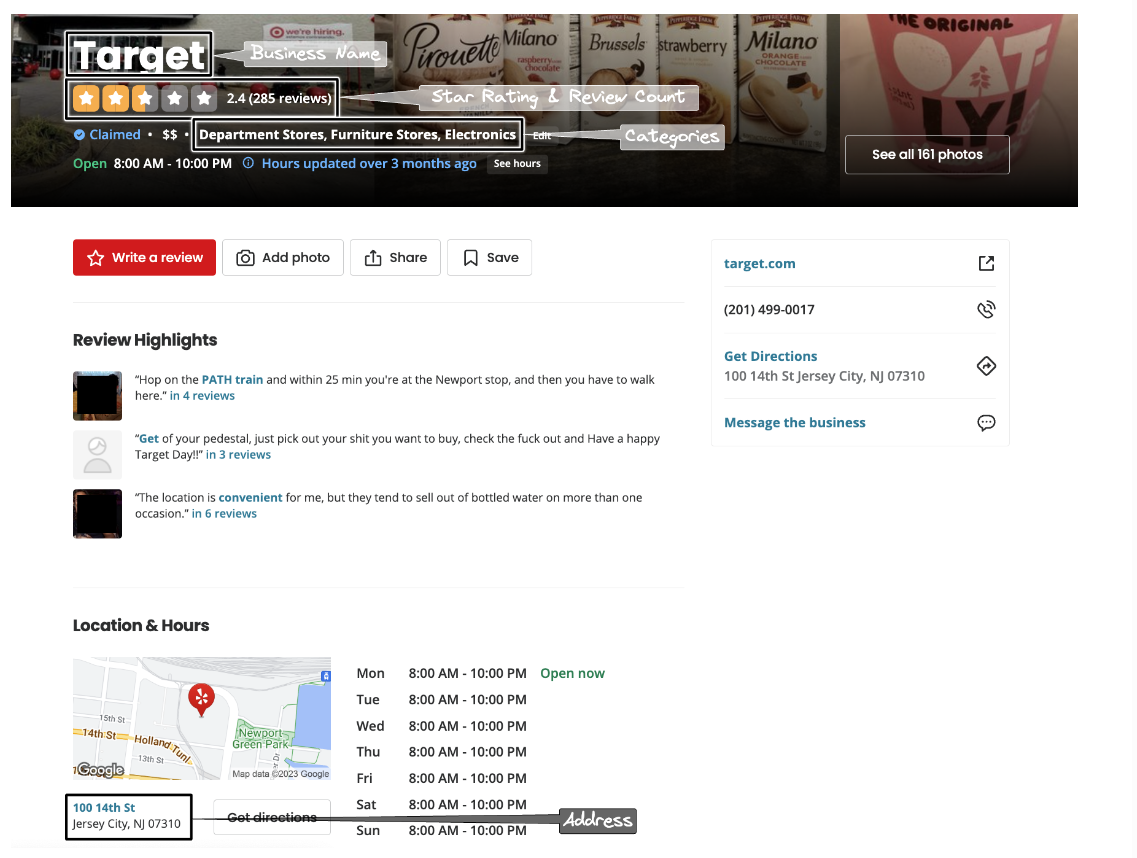

In [73]:
df_business = spark.read.json('yelp_academic_dataset_business.json')
print('The business data contains {} rows and {} columns'.format(df_business.count(), len(df_business.columns)),'\n')
print(df_business.printSchema(),'\n')

The business data contains 150346 rows and 14 columns 

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru

In [75]:
df_business.limit(3).toPandas().head()


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO
2,5255 E Broadway Blvd,"(None, None, None, None, None, None, None, Tru...",tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",Tucson,"(8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-2...",0,32.223236,-110.880452,Target,85711,22,3.5,AZ


## 2.1 Analyzing Unique, Missing, Duplicate Values

In [35]:
expr = [F.countDistinct(c).alias(c) for c in df_business.columns]
countdf =  df_business.select(*expr)
countdf.show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|  name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
| 122844|     67212|     150346|     83160|1416|49822|      2|  135593|   131918|114117|       3362|        1158|    9|   27|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+



##### Business id column contain all unique values

In [39]:
df_business.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_business.columns]
   ).show()

+-----------+----------+----+-------+----+-----------+------------+-----+-----+
|business_id|categories|city|is_open|name|postal_code|review_count|stars|state|
+-----------+----------+----+-------+----+-----------+------------+-----+-----+
|          0|       103|   0|      0|   0|          0|           0|    0|    0|
+-----------+----------+----+-------+----+-----------+------------+-----+-----+



##### Only categories column have missing values

In [79]:
df_business.dropDuplicates()

DataFrame[address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string

##### There are zero duplicate rows in business dataset

## 2.2 Handling Data Types

In [36]:
#  Handling Data Types

df_business = df_business.withColumn('stars', df_business['stars'].cast(FloatType()))

df_business = df_business.withColumn('review_count', df_business['review_count'].cast(IntegerType()))

## 2.3 Dropping Redundant Columns

In [37]:
# Dropping insignificant and redundant columns

df_business=df_business.drop('attributes','hours','latitude','longitude','address')

In [40]:
column_order = [
    "business_id",
    "name",
    "city",
    "state",
    "postal_code",
    "stars",
    "review_count"
]

df_business = df_business.select(column_order)
df_business.show(5)

+--------------------+--------------------+-------------+-----+-----------+-----+------------+
|         business_id|                name|         city|state|postal_code|stars|review_count|
+--------------------+--------------------+-------------+-----+-----------+-----+------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|Santa Barbara|   CA|      93101|  5.0|           7|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|       Affton|   MO|      63123|  3.0|          15|
|tUFrWirKiKi_TAnsV...|              Target|       Tucson|   AZ|      85711|  3.5|          22|
|MTSW4McQd7CbVtyjq...|  St Honore Pastries| Philadelphia|   PA|      19107|  4.0|          80|
|mWMc6_wTdE0EUBKIG...|Perkiomen Valley ...|   Green Lane|   PA|      18054|  4.5|          13|
+--------------------+--------------------+-------------+-----+-----------+-----+------------+
only showing top 5 rows



# 3. Preparing Review Data

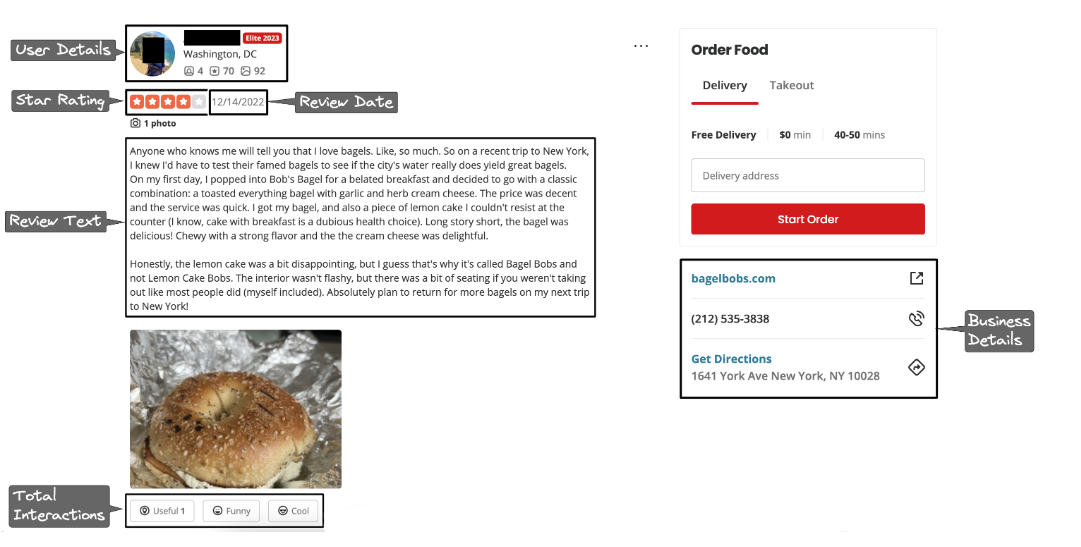

In [81]:
df_review=spark.read.json('yelp_academic_dataset_review.json')
print('The review data contains {} rows and {} columns'.format(df_review.count(), len(df_review.columns)),'\n')
print(df_review.printSchema(),'\n')

The review data contains 6990280 rows and 9 columns 

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

None 



In [82]:
df_review.limit(3).toPandas().head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,XQfwVwDr-v0ZS3_CbbE5Xw,0,2018-07-07 22:09:11,0,KU_O5udG6zpxOg-VcAEodg,3.0,"If you decide to eat here, just be aware it is...",0,mh_-eMZ6K5RLWhZyISBhwA
1,7ATYjTIgM3jUlt4UM3IypQ,1,2012-01-03 15:28:18,0,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,OyoGAe7OKpv6SyGZT5g77Q
2,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A


## 3.1 Analyzing Unique, Missing Values

In [43]:
# Counting unique values

expr = [F.countDistinct(c).alias(c) for c in df_review.columns]
countdf =  df_review.select(*expr)
countdf.show()

+-----------+----+-------+-----+---------+-----+-------+------+-------+
|business_id|cool|   date|funny|review_id|stars|   text|useful|user_id|
+-----------+----+-------+-----+---------+-----+-------+------+-------+
|     150346| 210|6885665|  201|  6990280|    5|6974127|   259|1987929|
+-----------+----+-------+-----+---------+-----+-------+------+-------+



In [44]:
# analyzing missing values

from pyspark.sql.functions import col,isnan, when, count

df_review.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_review.columns]
   ).show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



##### There are zero mising values in review dataset

## 3.2 Extarpolating new columns

In [45]:
# Extrapolating new columns

df_review=df_review.withColumn('review_year',year(df_review.date))
# df_review = df_review.withColumn('date', to_timestamp(df_review['date'], 'yyyy-MM-dd HH:mm:ss'))

## 3.3 Handling Data Types

In [46]:


df_review = df_review.withColumn('stars', df_review['stars'].cast(FloatType()))

cols=['useful','funny','cool']
for i in cols:
    df_review = df_review.withColumn(i, df_review[i].cast(IntegerType()))

## 3.4 Dropping Redundant columns

In [47]:
# Dropping redundant columns

df_review=df_review.drop('date')

# 4. Preparing Checkin Dataset

In [49]:
df_checkin = spark.read.json('yelp_academic_dataset_checkin.json')
print('The checkin data contains {} rows and {} columns'.format(df_checkin.count(), len(df_checkin.columns)),'\n')
print(df_checkin.printSchema(),'\n')

The checkin data contains 131930 rows and 2 columns 

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)

None 



In [50]:
df_checkin.limit(5).show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
+--------------------+--------------------+



## 4.1 Analyzing Unique, Missing Values

In [51]:
# Counting unique values

expr = [F.countDistinct(c).alias(c) for c in df_checkin.columns]
countdf =  df_checkin.select(*expr)
countdf.show()

+-----------+------+
|business_id|  date|
+-----------+------+
|     131930|131930|
+-----------+------+



In [52]:
# analyzing missing values

from pyspark.sql.functions import col,isnan, when, count

df_checkin.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_checkin.columns]
   ).show()

+-----------+----+
|business_id|date|
+-----------+----+
|          0|   0|
+-----------+----+



## 4.2 Extrapolating new columns

In [53]:
# Extrapolating new columns from existing columns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType, DateType

for column in df_checkin.columns:
    trimmed = psf.trim(psf.col(column))
    df_checkin = df_checkin.withColumn(
        column,
        psf.when(psf.length(trimmed) != 0, trimmed)
        .otherwise(None))

df_checkin=df_checkin.withColumn('list_date', f.split('date', ','))
df_checkin=df_checkin.select('*',size('list_date').alias('checkin_cnt'))
df_checkin = df_checkin.withColumn('checkin_cnt', when(col('checkin_cnt') == -1, 0).otherwise(col('checkin_cnt')))

def min_max_dates(date_str):
    dates = date_str.split(", ")
    dates.sort()  # Sort the list of dates in ascending order
    return (dates[0], dates[-1])

# Register the UDF
min_max_dates_udf = udf(min_max_dates, returnType=ArrayType(StringType()))

# Apply the UDF to create the min_date and max_date columns
df_checkin = df_checkin.withColumn("min_max_dates", min_max_dates_udf(col("date")))


# Split the min_max_dates array into two columns
df_checkin = df_checkin.withColumn("min_date", df_checkin["min_max_dates"][0])
df_checkin = df_checkin.withColumn("max_date", df_checkin["min_max_dates"][1])

df_checkin=df_checkin.withColumn('past_checkin_yr',year(df_checkin.min_date))
df_checkin=df_checkin.withColumn('recent_checkin_yr',year(df_checkin.max_date))

# Show the DataFrame with min_date and max_date columns
df_checkin.limit(10).show()

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------------+---------------+-----------------+
|         business_id|                date|           list_date|checkin_cnt|       min_max_dates|           min_date|           max_date|past_checkin_yr|recent_checkin_yr|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------------+---------------+-----------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|[2020-03-13 21:10...|         11|[2020-03-13 21:10...|2020-03-13 21:10:56|2021-11-11 16:23:50|           2020|             2021|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|[2010-09-13 21:43...|         10|[2010-09-13 21:43...|2010-09-13 21:43:09|2014-04-12 23:04:47|           2010|             2014|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|[2013-06-14 23:29...|          2|[2013-06-14 23:29...|2013-06-14 23:29:17|2014-08-13 23:20:22|   

## 4.3 Dropping Redundant Columns

In [54]:

cols = ['date', 'min_max_dates','min_date','max_date','list_date']
df_checkin = df_checkin.drop(*cols)

In [55]:
df_checkin.show(5)
df_checkin.printSchema()

+--------------------+-----------+---------------+-----------------+
|         business_id|checkin_cnt|past_checkin_yr|recent_checkin_yr|
+--------------------+-----------+---------------+-----------------+
|---kPU91CF4Lq2-Wl...|         11|           2020|             2021|
|--0iUa4sNDFiZFrAd...|         10|           2010|             2014|
|--30_8IhuyMHbSOcN...|          2|           2013|             2014|
|--7PUidqRWpRSpXeb...|         10|           2011|             2015|
|--7jw19RH9JKXgFoh...|         26|           2014|             2021|
+--------------------+-----------+---------------+-----------------+
only showing top 5 rows

root
 |-- business_id: string (nullable = true)
 |-- checkin_cnt: integer (nullable = false)
 |-- past_checkin_yr: integer (nullable = true)
 |-- recent_checkin_yr: integer (nullable = true)



# 5. Preparing Tip Dataset

In [56]:
df_tip = spark.read.json('yelp_academic_dataset_tip.json')
print('The tip data contains {} rows and {} columns'.format(df_tip.count(), len(df_tip.columns)),'\n')
print(df_tip.printSchema(),'\n')

The tip data contains 908915 rows and 5 columns 

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

None 



In [57]:
df_tip.limit(5).show()

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|ld0AperBXk1h6Ubqm...|
+--------------------+----------------+-------------------+--------------------+--------------------+



## 5.1 Analyzing Unique, Missing Values

In [59]:
# Counting unique values

expr = [F.countDistinct(c).alias(c) for c in df_tip.columns]
countdf =  df_tip.select(*expr)
countdf.show()

+-----------+----------------+------+------+-------+
|business_id|compliment_count|  date|  text|user_id|
+-----------+----------------+------+------+-------+
|     106193|               7|906694|851033| 301758|
+-----------+----------------+------+------+-------+



In [60]:
# analyzing missing values

from pyspark.sql.functions import col,isnan, when, count

df_tip.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_tip.columns]
   ).toPandas()

,business_id,compliment_count,date,text,user_id
0,0,0,0,0,0


## 5.2 Handling DataTypes

In [62]:
# handling datatypes

df_tip=df_tip.withColumn('tip_yr',year(df_tip.date))
df_tip = df_tip.withColumn("compliment_count", df_tip["compliment_count"].cast(IntegerType()))

In [63]:
df_tip.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tip_yr: integer (nullable = true)



# 6. Merging Datasets

In [69]:
df = df_review.select(
    col("review_id"),
    col("user_id"),
    col("business_id"),
    col("review_year"),
    col("stars").alias("review_stars"),
    col("text").alias("review_text"),
    col("useful").alias("review_useful"),
    col("funny").alias("review_funny"),
    col("cool").alias("review_cool")
)

df = df.join(
    df_user.select(
        col("user_id"),
        col("yelp_year").alias("user_yelp_year"),
        col("review_count").alias("user_review_count"),
        col("average_stars").alias("user_average_stars"),
        col("fans").alias("user_fans"),
        col("friends_cnt").alias("user_friends_cnt"),
        col("useful").alias("user_useful"),
        col("funny").alias("user_funny"),
        col("cool").alias("user_cool"),
        col("compliments_cnt").alias("user_compliments_cnt"),
        col("elite_cnt").alias("user_elite_cnt")
    ),
    on="user_id",
    how="left"
)

df = df.join(
    df_business.select(
        col("business_id"),
        col("name").alias("biz_name"),
        col("city").alias("biz_city"),
        col("state").alias("biz_state"),
        col("postal_code").alias("biz_postal_code"),
        col("stars").alias("biz_stars"),
        col("review_count").alias("biz_review_count")
    ),
    on="business_id",
    how="left"
)


df = df.join(
    df_checkin.select(
        col("business_id"),
        col("checkin_cnt").alias("checkin_count"),
        col("past_checkin_yr"),
        col("recent_checkin_yr")
    ),
    on="business_id",
    how="left"
)

df = df.join(
    df_tip.select(
        col("business_id"),
        col("text").alias("tip_text"),
        col("user_id"),
        col("tip_yr"),
        col("compliment_count").alias("tip_compliment_count")
    ),
    on=["business_id","user_id"],
    how="left"
)



In [70]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_year: integer (nullable = true)
 |-- review_stars: float (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_useful: integer (nullable = true)
 |-- review_funny: integer (nullable = true)
 |-- review_cool: integer (nullable = true)
 |-- user_yelp_year: integer (nullable = true)
 |-- user_review_count: integer (nullable = true)
 |-- user_average_stars: float (nullable = true)
 |-- user_fans: integer (nullable = true)
 |-- user_friends_cnt: integer (nullable = true)
 |-- user_useful: integer (nullable = true)
 |-- user_funny: integer (nullable = true)
 |-- user_cool: integer (nullable = true)
 |-- user_compliments_cnt: integer (nullable = true)
 |-- user_elite_cnt: integer (nullable = true)
 |-- biz_name: string (nullable = true)
 |-- biz_city: string (nullable = true)
 |-- biz_state: string (nullable = true)
 |-- biz_postal_code

In [71]:
df.limit(5).toPandas()

,business_id,user_id,review_id,review_year,review_stars,review_text,review_useful,review_funny,review_cool,user_yelp_year,user_review_count,user_average_stars,user_fans,user_friends_cnt,user_useful,user_funny,user_cool,user_compliments_cnt,user_elite_cnt,biz_name,biz_city,biz_state,biz_postal_code,biz_stars,biz_review_count,checkin_count,past_checkin_yr,recent_checkin_yr,tip_text,tip_yr,tip_compliment_count
0,TyxDzw8S02endZrrSHu_xQ,4DKWZqosj6bhu9U96PA61Q,Cpii8I_QMWLqCM9ZsEk_tg,2017,1.0,the young girl acted like she is an expert whi...,2,0,0,2017,1,1.00,0,1,2,0,0,0,0,Venus Nail and Spa,Nashville,TN,37203,3.5,138,44,2011,2020,"got SNS on Friday, couple days later 3 nails c...",2017.0,0.0
1,_pbx96FZ3eHJw-V_R4h-Vg,7ZrxKSXQKb7A7QF_CJVOqg,8H81chukQT03OySkDxb01w,2014,4.0,Overall this place is great! I just stayed at ...,3,0,1,2014,11,3.82,0,16,14,3,9,1,0,Embassy Suites by Hilton Tampa USF Near Busch ...,Tampa,FL,33612,2.5,83,250,2010,2021,None,NaN,NaN
2,iCVrRHR_Yxr6mHCpObnE1g,61yZ26RhF0g_bdumzD0yWg,gpfdsvpQWSBAcYRtK0-KNA,2015,5.0,I have been searching for a good thai place in...,0,1,0,2012,29,4.17,0,1,21,8,8,2,0,AmeriThai,Philadelphia,PA,19148,4.0,120,100,2014,2020,None,NaN,NaN
3,l7G__JgJviXZ6DEOk2C1EA,3hx-p41hR6cYygitmUlH4w,XU9hyEzOQv8QWMA3kf4Qkw,2013,5.0,"Visited Zoom Room on their opening day, and fi...",0,0,0,2012,23,3.50,0,8,26,8,5,0,0,Zoom Room Dog Training,Philadelphia,PA,19123,5.0,36,55,2013,2017,None,NaN,NaN
4,qUw40fUsB7jPCxJ2qRlm5w,1QOjpd-Bai_pWDob7WcurA,Vgagw9s9kbGgY-yDvJaDwQ,2021,5.0,First time my wife and I have been to this bar...,0,0,0,2013,6,5.00,0,1,3,0,1,0,0,Paddywagon Dunedin,Clearwater,FL,33763,5.0,5,3,2020,2021,None,NaN,NaN


In [72]:
print('The final merged dataset contains {} rows and {} columns'.format(df.count(), len(df.columns)),'\n')

The final merged dataset contains 7103760 rows and 31 columns 



# 7. Exporting Data

In [ ]:
# Define the JDBC connection details
jdbc_url = "jdbc:postgresql://intentionally-removed.amazonaws.com/yelpreviewsense"
db_table = ""
db_user = "postgres"
db_password = ""

# Specify the DataFrame write options
write_options = {
    "url": jdbc_url,
    "driver": "org.postgresql.Driver",
    "dbtable": db_table,
    "user": db_user,
    "password": db_password,
}

# Write the DataFrame to the PostgreSQL database
df.write.format("jdbc").options(**write_options).mode("overwrite").save()